# Libraries

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# Warnings

In [72]:
# Suppress specific warning message
warnings.filterwarnings("ignore", message=".*A worker stopped while some jobs were given to the executor.*")

# Data

In [73]:
# Load data from CSV into a DataFrame
df = pd.read_csv('data.csv')

# Remove the 'LoanID' column
df = df.drop(columns='LoanID')

# Show the first 5 rows
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [74]:
# List of categorical variables that need to be one-hot encoded for model fitting
categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus',
                       'HasMortgage', 'HasDependents', 'LoanPurpose',
                       'HasCoSigner']

# Perform one-hot encoding on categorical columns
df = pd.get_dummies(df,
                    columns=categorical_columns,
                    drop_first=True,  # Drops the first category to avoid multicollinearity
                    dtype=int  # Ensures the new dummy variables are of integer type
                   )

# Show the first 5 rows of DataFrame with one-hot encoding
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,0,...,0,0,0,1,1,0,0,0,1,1
1,69,50432,124440,458,15,1,4.81,60,0.68,0,...,0,1,0,0,0,0,0,0,1,1
2,46,84208,129188,451,26,3,21.17,24,0.31,1,...,1,0,0,1,1,0,0,0,0,0
3,32,31713,44799,743,0,3,7.07,24,0.23,0,...,0,1,0,0,0,1,0,0,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,1,0,0,0,1,0,0,0,0,0


In [75]:
# Get design matrix
X = df.drop(columns=['Default'])

# Get response
y = df['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  # Use 20% of the data for testing
                                                    random_state=42  # Set random seed for reproducibility
                                                   )

In [76]:
# Combine the training design matrix and training response into single DataFrame
train_data = pd.concat([X_train, y_train], 
                       axis=1  # Combine horizontally to align features with the response
                      )

# Extract observations belonging to the majority class in the training set
majority_obs = train_data[ train_data['Default'] == 0 ]

# Extract observations belonging to the minority class in the training set
minority_obs = train_data[ train_data['Default'] == 1 ]

# Perform random downsampling on majority class observations
majority_obs_downsampled = resample(majority_obs,
                                    replace=False,  # Sample without replacement
                                    n_samples=len(minority_obs),  # Match the size of the minority class
                                    random_state=42  # Set random seed for reproducibility
                                    )

# Combine the downsampled majority class observations with the minority class observations
train_data_downsampled = pd.concat([majority_obs_downsampled, minority_obs])

# Split the downsampled training data into the design matrix and response
X_train_downsampled = train_data_downsampled.drop(columns=['Default'])
y_train_downsampled = train_data_downsampled['Default']

# Model Fitting

## No Downsampling

### Classification Tree

In [77]:
# Define the parameter grid for hyperparameter tuning of the classification tree 
param_grid_ct = {
    'max_depth': [5, 10, 15, 20, 25, 30],  # Possible maximum depths for tree
    'min_samples_leaf': [1, 2, 5, 10]  # Minimum number of observations required at a leaf node
}

# Set up GridSearchCV for the decision tree classifier
grid_search_ct = GridSearchCV(DecisionTreeClassifier(random_state=42),  # Decision tree classifier with fixed random state for reproducibility
                              param_grid_ct,  # The defined parameter grid for hyperparameter tuning 
                              cv=5,  # Perform 5-fold cross-validation to evaluate the model
                              scoring='f1',  # Use F1 score as the metric for model evaluation
                              n_jobs=-1  # Use all available resources to speed up the grid search process
                             )

# Fit the classification tree using grid search to the training data
grid_search_ct.fit(X_train, y_train)

# Get and output the selected hyperparameters via grid search
best_params_ct = grid_search_ct.best_params_
print(f'Best Hyperparameters:', best_params_ct)

Best Hyperparameters: {'max_depth': 25, 'min_samples_leaf': 1}


In [78]:
# Retrieve the best classification tree model from the grid search (this will be the model with the optimal hyperparameters)
best_ct = grid_search_ct.best_estimator_

# Use the best model to get the predicted probabilities of the positive class (class 1) for the test
y_pred_proba_ct = best_ct.predict_proba(X_test)[:, 1]  # Extract probabilities of the positive class ([:, 0] would get probabilities of negative class)

# Initialize variables to track the best cutoff and the corresponding best F1 score
best_cutoff_ct = 0
best_f1_ct = 0 

# Iterate through possible cutoff values between 0 and 1 in increments of 0.01
for cutoff in np.arange(0, 1.01, 0.01):
    
    # Classify predictions as 1 if the probability is greater than or equal to the cutoff, otherwise as 0
    cutoff_classifications = (y_pred_proba_ct >= cutoff).astype(int)
    
    # Calculate the F1 score for the current cutoff
    f1 = f1_score(y_test, cutoff_classifications)
    
    # Update the best cutoff and F1 score if the current F1 score is better
    if f1 > best_f1_ct:
        best_f1_ct = f1
        best_cutoff_ct = cutoff

# Output the best cutoff
print("Best Cutoff:", best_cutoff_ct)

Best Cutoff: 0.07


In [79]:
# Apply the best cutoff to the predicted probabilities to classify observations as 0 or 1
best_cutoff_classifications_ct = (y_pred_proba_ct >= best_cutoff_ct).astype(int)

# Calculate Accuracy, Precision, Recall, and F1 score using the best cutoff
accuracy_ct = round(accuracy_score(y_test, best_cutoff_classifications_ct), 4)
precision_ct = round(precision_score(y_test, best_cutoff_classifications_ct), 4)
recall_ct = round(recall_score(y_test, best_cutoff_classifications_ct), 4)
f1_ct = round(f1_score(y_test, best_cutoff_classifications_ct), 4)

# Output the evaluation metrics
print("Accuracy:", accuracy_ct)
print("Precision:", precision_ct)
print("Recall:", recall_ct)
print("F1 Score:", f1_ct)

Accuracy: 0.7902
Precision: 0.1889
Recall: 0.2478
F1 Score: 0.2144


### Random Forest

In [80]:
# Define the parameter grid for hyperparameter tuning of the random forest model
param_grid_rf = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [5, 10, 15, 20, 25],  # Possible maximum depths for each tree
    'min_samples_leaf': [1, 2, 5, 10]  # Minimum number of observations required at a leaf node
}

# Set up GridSearchCV for the random forest classifier
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),  # Random forest classifier with fixed random state for reproducibility
                              param_grid_rf,  # The defined parameter grid for hyperparameter tuning
                              cv=5,  # Perform 5-fold cross-validation to evaluate the model
                              scoring='f1',  # Use F1 score as the metric for model evaluation
                              n_jobs=-1  # Use all available resources to speed up the grid search process
                             )

# Fit the random forest model using grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Get and output the selected hyperparameters via grid search
best_params_rf = grid_search_rf.best_params_
print(f'Best Hyperparameters:', best_params_rf)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 50}


In [81]:
# Retrieve the best random forest model from the grid search (this will be the model with the optimal hyperparameters)
best_rf = grid_search_rf.best_estimator_

# Use the best model to get the predicted probabilities of the positive class (class 1) for the test set
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]  # Extract probabilities of the positive class ([:, 0] would get probabilities of the negative class)

# Initialize variables to track the best cutoff and the corresponding best F1 score
best_cutoff_rf = 0
best_f1_rf = 0 

# Iterate through possible cutoff values between 0 and 1 in increments of 0.01
for cutoff in np.arange(0, 1.01, 0.01):
    
    # Classify predictions as 1 if the probability is greater than or equal to the cutoff, otherwise as 0
    cutoff_classifications = (y_pred_proba_rf >= cutoff).astype(int)
    
    # Calculate the F1 score for the current cutoff
    f1 = f1_score(y_test, cutoff_classifications)
    
    # Update the best cutoff and F1 score if the current F1 score is better
    if f1 > best_f1_rf:
        best_f1_rf = f1
        best_cutoff_rf = cutoff

# Output the best cutoff
print("Best Cutoff:", best_cutoff_rf)

Best Cutoff: 0.2


In [82]:
# Apply the best cutoff to the predicted probabilities to classify observations as 0 or 1
best_cutoff_classifications_rf = (y_pred_proba_rf >= best_cutoff_rf).astype(int)

# Calculate Accuracy, Precision, Recall, and F1 score using the best cutoff
accuracy_rf = round(accuracy_score(y_test, best_cutoff_classifications_rf), 4)
precision_rf = round(precision_score(y_test, best_cutoff_classifications_rf), 4)
recall_rf = round(recall_score(y_test, best_cutoff_classifications_rf), 4)
f1_rf = round(f1_score(y_test, best_cutoff_classifications_rf), 4)

# Output the evaluation metrics
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

Accuracy: 0.8002
Precision: 0.277
Recall: 0.4532
F1 Score: 0.3439


### Logistic Regression

In [83]:
# Define the parameter grid for hyperparameter tuning of the logistic regression model
param_grid_lr = {
    'penalty': ['l1', 'l2'],  # Regularization types: L1 and L2
    'C': [0.01, 0.1, 1, 10]  # Inverse of regularization strength
}

# Set up GridSearchCV for the logistic regression model
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=8000, solver='saga'),  # Use 'saga' solver to handle both L1 and L2
                              param_grid_lr,  # The defined parameter grid for hyperparameter tuning
                              cv=5,  # Perform 5-fold cross-validation to evaluate the model
                              scoring='f1',  # Use F1 score as the metric for model evaluation
                              n_jobs=-1  # Use all available resources to speed up the grid search process
                             )

# Fit the logistic regression model using grid search to the training data
grid_search_lr.fit(X_train, y_train)

# Get and output the selected hyperparameters via grid search
best_params_lr = grid_search_lr.best_params_
print(f'Best Hyperparameters:', best_params_lr)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l1'}


In [84]:
# Retrieve the best logistic regression model from the grid search (this will be the model with the optimal hyperparameters)
best_lr = grid_search_lr.best_estimator_

# Use the best model to get the predicted probabilities of the positive class (class 1) for the test set
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]  # Extract probabilities of the positive class ([:, 0] would get probabilities of the negative class)

# Initialize variables to track the best cutoff and the corresponding best F1 score
best_cutoff_lr = 0
best_f1_lr = 0 

# Iterate through possible cutoff values between 0 and 1 in increments of 0.01
for cutoff in np.arange(0, 1.01, 0.01):
    
    # Classify predictions as 1 if the probability is greater than or equal to the cutoff, otherwise as 0
    cutoff_classifications = (y_pred_proba_lr >= cutoff).astype(int)
    
    # Calculate the F1 score for the current cutoff
    f1 = f1_score(y_test, cutoff_classifications)
    
    # Update the best cutoff and F1 score if the current F1 score is better
    if f1 > best_f1_lr:
        best_f1_lr = f1
        best_cutoff_lr = cutoff

# Output the best cutoff
print("Best Cutoff:", best_cutoff_lr)

Best Cutoff: 0.15


In [85]:
# Apply the best cutoff to the predicted probabilities to classify observations as 0 or 1
best_cutoff_classifications_lr = (y_pred_proba_lr >= best_cutoff_lr).astype(int)

# Calculate Accuracy, Precision, Recall, and F1 score using the best cutoff
accuracy_lr = round(accuracy_score(y_test, best_cutoff_classifications_lr), 4)
precision_lr = round(precision_score(y_test, best_cutoff_classifications_lr), 4)
recall_lr = round(recall_score(y_test, best_cutoff_classifications_lr), 4)
f1_lr = round(f1_score(y_test, best_cutoff_classifications_lr), 4)

# Output the evaluation metrics
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)

Accuracy: 0.7468
Precision: 0.2279
Recall: 0.499
F1 Score: 0.3129


## Downsampling

### Classification Tree

In [86]:
# Define the parameter grid for hyperparameter tuning of the classification tree 
param_grid_ct_downsampled = {
    'max_depth': [5, 10, 15, 20, 25, 30], # Possible maximum depths for tree
    'min_samples_leaf': [1, 2, 5, 10], # Minimum number of observations required at a leaf node
}

# Set up GridSearchCV for the decision tree classifier
grid_search_ct_downsampled = GridSearchCV(DecisionTreeClassifier(random_state=42), # Decision tree classifier with fixed random state for reproducibility
                              param_grid_ct_downsampled, # The defined parameter grid for hyperparameter tuning 
                              cv=5, # Perform 5-fold cross-validation to evaluate the model
                              scoring='f1', # Use F1 score as the metric for model evaluation
                              n_jobs=-1 # Use all available resources to speed up the grid search process
                              )

# Fit the classification tree using grid search to the downsampled training data
grid_search_ct_downsampled.fit(X_train_downsampled, y_train_downsampled)

# Get and output the selected hyperparameters via grid search
best_params_ct_downsampled = grid_search_ct_downsampled.best_params_
print(f'Best Hyperparameters:', best_params_ct_downsampled)

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1}


In [87]:
# Retrieve the best classification tree model from the grid search (this will be the model with the optimal hyperparameters)
best_ct_downsampled = grid_search_ct_downsampled.best_estimator_

# Use the best model to get the predicted probabilities of the positive class (class 1) for the test
y_pred_proba_ct_downsampled = best_ct_downsampled.predict_proba(X_test)[:, 1] # Extract probabilities of the positive class ([:, 0] would get probabilities of negative class)

# Initialize variables to track the best cutoff and the corresponding best F1 score
best_cutoff_ct_downsampled = 0
best_f1_ct_downsampled = 0 

# Iterate through possible cutoff values between 0 and 1 in increments of 0.01
for cutoff in np.arange(0, 1.01, 0.01):
    
    # Classify predictions as 1 if the probability is greater than or equal to the cutoff, otherwise as 0
    cutoff_classifications = (y_pred_proba_ct_downsampled >= cutoff).astype(int)
    
    # Calculate the F1 score for the current cutoff
    f1 = f1_score(y_test, cutoff_classifications)
    
    # Update the best cutoff and F1 score if the current F1 score is better
    if f1 > best_f1_ct_downsampled:
        best_f1_ct_downsampled = f1
        best_cutoff_ct_downsampled = cutoff

# Output the best cutoff
print("Best Cutoff:", best_cutoff_ct_downsampled)

Best Cutoff: 0.59


In [88]:
# Apply the best cutoff to the predicted probabilities to classify observations as 0 or 1
best_cutoff_classifications_ct_downsampled = (y_pred_proba_ct_downsampled >= best_cutoff_ct_downsampled).astype(int)

# Calculate Accuracy, Precision, Recall, and F1 score using the best cutoff
accuracy_ct_downsampled = round(accuracy_score(y_test, best_cutoff_classifications_ct_downsampled), 4)
precision_ct_downsampled = round(precision_score(y_test, best_cutoff_classifications_ct_downsampled), 4)
recall_ct_downsampled = round(recall_score(y_test, best_cutoff_classifications_ct_downsampled), 4)
f1_ct_downsampled = round(f1_score(y_test, best_cutoff_classifications_ct_downsampled), 4)

# Output the evaluation metrics
print("Accuracy:", accuracy_ct_downsampled)
print("Precision:", precision_ct_downsampled)
print("Recall:", recall_ct_downsampled)
print("F1 Score:", f1_ct_downsampled)

Accuracy: 0.7536
Precision: 0.2377
Recall: 0.5132
F1 Score: 0.3249


### Random Forest

In [89]:
# Define the parameter grid for hyperparameter tuning of the random forest model
param_grid_rf_downsampled = {
    'n_estimators': [50, 100, 150], # Number of trees in the forest
    'max_depth': [5, 10, 15, 20, 25], # Possible maximum depths for each tree
    'min_samples_leaf': [1, 2, 5, 10] # Minimum number of observations required at a leaf node
}

# Set up GridSearchCV for the random forest classifier
grid_search_rf_downsampled = GridSearchCV(RandomForestClassifier(random_state=42), # Random forest classifier with fixed random state for reproducibility
                              param_grid_rf_downsampled, # The defined parameter grid for hyperparameter tuning
                              cv=5, # Perform 5-fold cross-validation to evaluate the model
                              scoring='f1', # Use F1 score as the metric for model evaluation
                              n_jobs=-1 # Use all available resources to speed up the grid search process
                             )

# Fit the random forest model using grid search to the downsampled training data
grid_search_rf_downsampled.fit(X_train_downsampled, y_train_downsampled)

# Get and output the selected hyperparameters via grid search
best_params_rf_downsampled = grid_search_rf_downsampled.best_params_
print(f'Best Hyperparameters:', best_params_rf_downsampled)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 50}


In [90]:
# Retrieve the best random forest model from the grid search (this will be the model with the optimal hyperparameters)
best_rf_downsampled = grid_search_rf_downsampled.best_estimator_

# Use the best model to get the predicted probabilities of the positive class (class 1) for the test set
y_pred_proba_rf_downsampled = best_rf_downsampled.predict_proba(X_test)[:, 1] # Extract probabilities of the positive class ([:, 0] would get probabilities of the negative class)

# Initialize variables to track the best cutoff and the corresponding best F1 score
best_cutoff_rf_downsampled = 0
best_f1_rf_downsampled = 0 

# Iterate through possible cutoff values between 0 and 1 in increments of 0.01
for cutoff in np.arange(0, 1.01, 0.01):
    
    # Classify predictions as 1 if the probability is greater than or equal to the cutoff, otherwise as 0
    cutoff_classifications = (y_pred_proba_rf_downsampled >= cutoff).astype(int)
    
    # Calculate the F1 score for the current cutoff
    f1 = f1_score(y_test, cutoff_classifications)
    
    # Update the best cutoff and F1 score if the current F1 score is better
    if f1 > best_f1_rf_downsampled:
        best_f1_rf_downsampled = f1
        best_cutoff_rf_downsampled = cutoff

# Output the best cutoff
print("Best Cutoff:", best_cutoff_rf_downsampled)

Best Cutoff: 0.59


In [91]:
# Apply the best cutoff to the predicted probabilities to classify observations as 0 or 1
best_cutoff_classifications_rf_downsampled = (y_pred_proba_rf_downsampled >= best_cutoff_rf_downsampled).astype(int)

# Calculate Accuracy, Precision, Recall, and F1 score using the best cutoff
accuracy_rf_downsampled = round(accuracy_score(y_test, best_cutoff_classifications_rf_downsampled), 4)
precision_rf_downsampled = round(precision_score(y_test, best_cutoff_classifications_rf_downsampled), 4)
recall_rf_downsampled = round(recall_score(y_test, best_cutoff_classifications_rf_downsampled), 4)
f1_rf_downsampled = round(f1_score(y_test, best_cutoff_classifications_rf_downsampled), 4)

# Output the evaluation metrics
print("Accuracy:", accuracy_rf_downsampled)
print("Precision:", precision_rf_downsampled)
print("Recall:", recall_rf_downsampled)
print("F1 Score:", f1_rf_downsampled)

Accuracy: 0.7987
Precision: 0.2858
Recall: 0.4949
F1 Score: 0.3623


### Logistic Regression

In [92]:
# Define the parameter grid for hyperparameter tuning of the logistic regression model
param_grid_lr_downsampled = {
    'penalty': ['l1', 'l2'],  # Regularization types: L1 and L2
    'C': [0.01, 0.1, 1, 10]  # Inverse of regularization strength
}

# Set up GridSearchCV for the logistic regression model
grid_search_lr_downsampled = GridSearchCV(LogisticRegression(random_state=42, max_iter=8000, solver='saga'),  # Use 'saga' solver to handle both L1 and L2
                              param_grid_lr_downsampled,  # The defined parameter grid for hyperparameter tuning
                              cv=5,  # Perform 5-fold cross-validation to evaluate the model
                              scoring='f1',  # Use F1 score as the metric for model evaluation
                              n_jobs=-1  # Use all available resources to speed up the grid search process
                             )

# Fit the logistic regression model using grid search to the downsampled training data
grid_search_lr_downsampled.fit(X_train_downsampled, y_train_downsampled);

# Get and output the selected hyperparameters via grid search
best_params_lr_downsampled = grid_search_lr_downsampled.best_params_
print(f'Best Hyperparameters:', best_params_lr_downsampled)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l2'}


In [93]:
# Retrieve the best logistic regression model from the grid search (this will be the model with the optimal hyperparameters)
best_lr_downsampled = grid_search_lr_downsampled.best_estimator_

# Use the best model to get the predicted probabilities of the positive class (class 1) for the test set
y_pred_proba_lr_downsampled = best_lr_downsampled.predict_proba(X_test)[:, 1]  # Extract probabilities of the positive class ([:, 0] would get probabilities of the negative class)

# Initialize variables to track the best cutoff and the corresponding best F1 score
best_cutoff_lr_downsampled = 0
best_f1_lr_downsampled = 0 

# Iterate through possible cutoff values between 0 and 1 in increments of 0.01
for cutoff in np.arange(0, 1.01, 0.01):
    
    # Classify predictions as 1 if the probability is greater than or equal to the cutoff, otherwise as 0
    cutoff_classifications = (y_pred_proba_lr_downsampled >= cutoff).astype(int)
    
    # Calculate the F1 score for the current cutoff
    f1 = f1_score(y_test, cutoff_classifications)
    
    # Update the best cutoff and F1 score if the current F1 score is better
    if f1 > best_f1_lr_downsampled:
        best_f1_lr_downsampled = f1
        best_cutoff_lr_downsampled = cutoff

# Output the best cutoff
print("Best Cutoff:", best_cutoff_lr_downsampled)

Best Cutoff: 0.54


In [94]:
# Apply the best cutoff to the predicted probabilities to classify observations as 0 or 1
best_cutoff_classifications_lr_downsampled = (y_pred_proba_lr_downsampled >= best_cutoff_lr_downsampled).astype(int)

# Calculate Accuracy, Precision, Recall, and F1 score using the best cutoff
accuracy_lr_downsampled = round(accuracy_score(y_test, best_cutoff_classifications_lr_downsampled), 4)
precision_lr_downsampled = round(precision_score(y_test, best_cutoff_classifications_lr_downsampled), 4)
recall_lr_downsampled = round(recall_score(y_test, best_cutoff_classifications_lr_downsampled), 4)
f1_lr_downsampled = round(f1_score(y_test, best_cutoff_classifications_lr_downsampled), 4)

# Output the evaluation metrics
print("Accuracy:", accuracy_lr_downsampled)
print("Precision:", precision_lr_downsampled)
print("Recall:", recall_lr_downsampled)
print("F1 Score:", f1_lr_downsampled)

Accuracy: 0.7324
Precision: 0.2137
Recall: 0.4914
F1 Score: 0.2979


## Comparison

In [95]:
# Create a dictionary with the performance metrics for both non-downsampled and downsampled models
performance_metrics = {
    'Accuracy': [accuracy_ct, accuracy_rf, accuracy_lr, accuracy_ct_downsampled, accuracy_rf_downsampled, accuracy_lr_downsampled],
    'Precision': [precision_ct, precision_rf, precision_lr, precision_ct_downsampled, precision_rf_downsampled, precision_lr_downsampled],
    'Recall': [recall_ct, recall_rf, recall_lr, recall_ct_downsampled, recall_rf_downsampled, recall_lr_downsampled],
    'F1 Score': [f1_ct, f1_rf, f1_lr, f1_ct_downsampled, f1_rf_downsampled, f1_lr_downsampled],
    'Best Cutoff': [best_cutoff_ct, best_cutoff_rf, best_cutoff_lr, best_cutoff_ct_downsampled, best_cutoff_rf_downsampled, best_cutoff_lr_downsampled]
}

# Create the index for the DataFrame
index = [
    'Classification Tree - Non-Downsampling',
    'Random Forest - Non-Downsampling',
    'Logistic Regression - Non-Downsampling',
    'Classification Tree - Downsampling',
    'Random Forest - Downsampling',
    'Logistic Regression - Downsampling'
]

# Create the DataFrame
performance_metrics_df = pd.DataFrame(performance_metrics, index=index)

# Display the DataFrame
performance_metrics_df

,Accuracy,Precision,Recall,F1 Score,Best Cutoff
Classification Tree - Non-Downsampling,0.7902,0.1889,0.2478,0.2144,0.07
Random Forest - Non-Downsampling,0.8002,0.2770,0.4532,0.3439,0.20
Logistic Regression - Non-Downsampling,0.7468,0.2279,0.4990,0.3129,0.15
Classification Tree - Downsampling,0.7536,0.2377,0.5132,0.3249,0.59
Random Forest - Downsampling,0.7987,0.2858,0.4949,0.3623,0.59
Logistic Regression - Downsampling,0.7324,0.2137,0.4914,0.2979,0.54


# Feature Importance

In [96]:
# Compute the permutation feature importance of the random forest with downsampling using the F1 score as the performance metric
perm_importance = permutation_importance(
    best_rf_downsampled,
    X_test,
    y_test,
    scoring='f1',  # F1 score as the evaluation metric
    n_repeats=10,  # Number of permutations per feature
    random_state=42,  # Seed for reproducibility
    n_jobs=-1  # Use all available resources
)

# Extract the mean change in F1 score for each feature
mean_importance = perm_importance.importances_mean

# Get the feature names from the test set
feature_names = X_test.columns

# Create a DataFrame to hold features and their corresponding mean importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Change in F1 Score': mean_importance
})

# Sort the features by mean importance in descending order
importance_df = importance_df.sort_values(by='Mean Change in F1 Score', ascending=False)

# Ouput the DataFrame
importance_df

,Feature,Mean Change in F1 Score
0,Age,0.064765
6,InterestRate,0.033890
1,Income,0.021902
4,MonthsEmployed,0.016062
2,LoanAmount,0.014650
23,HasCoSigner_Yes,0.001725
3,CreditScore,0.001275
5,NumCreditLines,0.001045
8,DTIRatio,0.000823
14,EmploymentType_Unemployed,0.000818


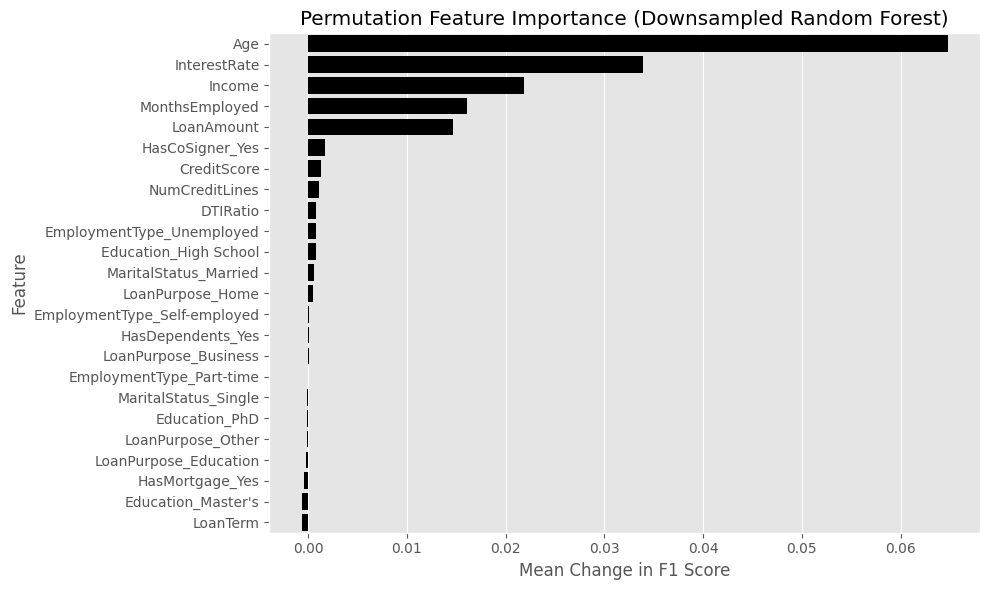

In [97]:
# Set plot style
plt.style.use('ggplot')

# Set figure size 
plt.figure(figsize=(10, 6))

# Create bar plot to visualize permutation feature importance
sns.barplot(x='Mean Change in F1 Score',
            y='Feature',
            data=importance_df,
            color='black')

# Set title, x-axis, and y-label of plot
plt.title('Permutation Feature Importance (Downsampled Random Forest)')
plt.xlabel('Mean Change in F1 Score')
plt.ylabel('Feature')

# Automatically adjust plot spacing
plt.tight_layout()

# Show plot
plt.show()